# Smart Refrigerator Anomaly Detection - Model Training
## Complete Pipeline: Data Loading → Feature Extraction → Training → Validation → Export

**Hardware:** ESP32-S3 with MPU6050 + INA226  
**Model:** Random Forest Classifier (30 trees)  
**Target Accuracy:** >95%


## Cell 1: Install Required Packages

In [1]:
# Run this ONCE to install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn scipy joblib

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


## Cell 2: Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


✓ Libraries imported successfully
NumPy version: 2.3.3
Pandas version: 2.3.2


## Cell 3: Configure Paths and Parameters

In [3]:
# ===== FILE PATHS =====
# Update these paths to match your file locations
DATA_DIR = "./"

# # Single-surface files
# DATA_FILES_SINGLE = {
#     'NORMAL': DATA_DIR + 'normal/session1a_normal_wood_cleaned.csv',
# }

NORMAL_FILES = {
    'wood': DATA_DIR + 'normal_clean.csv',
}

# Multi-surface files
BEARING_WEAR_FILES = {
    'wood': DATA_DIR + 'bearing_wear_clean.csv',

}

IMBALANCE_FILES = {
    'wood': DATA_DIR + 'imbalance_clean.csv',
}

ELECTRICAL_FILES = {
    'wood': DATA_DIR + 'electrical_clean.csv',
}


# VALIDATION_FILES = {
#     'NORMAL': DATA_DIR + 'normal_clean.csv',
#     'BEARING_WEAR': DATA_DIR + 'bearing_wear_clean.csv',
#     'IMBALANCE': DATA_DIR + 'imbalance_clean.csv',
#     'ELECTRICAL': DATA_DIR + 'electrical_clean.csv',
# }

# ===== PARAMETERS =====
WINDOW_SIZE = 1000  # 1 second at 1 kHz
OVERLAP = 0  # No overlap (can change to 500 for 50% overlap)
SAMPLING_RATE = 1000  # Hz

# Class labels
CLASS_LABELS = {
    0: 'NORMAL',
    1: 'BEARING_WEAR',
    2: 'IMBALANCE',
    3: 'ELECTRICAL'
}

print("✓ Configuration complete")
print(f"Window size: {WINDOW_SIZE} samples ({WINDOW_SIZE/SAMPLING_RATE} seconds)")
print(f"Overlap: {OVERLAP} samples")
print(f"Classes: {list(CLASS_LABELS.values())}")

# Verify files
import os
print("\n" + "="*70)
print("FILE VERIFICATION")
print("="*70)

all_files_ok = True

print("\n NORMAL FILES:")
for surface, filepath in NORMAL_FILES.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {surface:10s}: {size_mb:6.1f} MB")
    else:
        print(f"  ✗ {surface:10s}: NOT FOUND")
        all_files_ok = False


print("\nELECTRICAL FILES:")
for surface, filepath in ELECTRICAL_FILES.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {surface:10s}: {size_mb:6.1f} MB")
    else:
        print(f"  ✗ {surface:10s}: NOT FOUND")
        all_files_ok = False


print("\nBEARING_WEAR FILES:")
for surface, filepath in BEARING_WEAR_FILES.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {surface:10s}: {size_mb:6.1f} MB")
    else:
        print(f"  ✗ {surface:10s}: NOT FOUND")
        all_files_ok = False

print("\nIMBALANCE FILES:")
for surface, filepath in IMBALANCE_FILES.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {surface:10s}: {size_mb:6.1f} MB")
    else:
        print(f"  ✗ {surface:10s}: NOT FOUND")
        all_files_ok = False

print("\nVALIDATION FILES:")
for class_name, filepath in VALIDATION_FILES.items():
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {class_name:15s}: {size_mb:6.1f} MB")
    else:
        print(f"  ⚠ {class_name:15s}: NOT FOUND")

print("\n" + "="*70)
if all_files_ok:
    print("✓ ALL REQUIRED FILES FOUND - Ready to proceed!")
else:
    print("✗ MISSING FILES - Please check paths and filenames")
print("="*70)

✓ Configuration complete
Window size: 1000 samples (1.0 seconds)
Overlap: 0 samples
Classes: ['NORMAL', 'BEARING_WEAR', 'IMBALANCE', 'ELECTRICAL']

FILE VERIFICATION

 NORMAL FILES:
  ✓ wood      :  103.9 MB

ELECTRICAL FILES:
  ✓ wood      :  100.6 MB

BEARING_WEAR FILES:
  ✓ wood      :  101.3 MB

IMBALANCE FILES:
  ✓ wood      :  104.8 MB

VALIDATION FILES:
  ⚠ NORMAL         : NOT FOUND
  ⚠ BEARING_WEAR   : NOT FOUND
  ⚠ IMBALANCE      : NOT FOUND
  ✓ ELECTRICAL     :   50.9 MB

✓ ALL REQUIRED FILES FOUND - Ready to proceed!


## Cell 4: Load and Inspect Raw Data

In [4]:
def load_csv_data(filepath, class_label, surface_name=""):
    """
    Load CSV data from ESP32 logger.
    CSV format: time_ms,accel_mag_g,fan_pwm,vibration_pwm,current_a,event_code
    """
    surface_str = f" ({surface_name})" if surface_name else ""
    print(f"Loading{surface_str}: {os.path.basename(filepath)}")
    
    # Read CSV WITH header row
    df = pd.read_csv(
        filepath,
        comment='#',
        header=0,
        skipinitialspace=True,
        on_bad_lines='skip'
    )
    
    # Rename columns to match expected names
    df = df.rename(columns={
        'accel_mag_g': 'accel_mag',
        'vibration_pwm': 'vib_pwm',
        'current_a': 'current'
    })
    
    # Ensure all columns are numeric
    numeric_cols = ['time_ms', 'accel_mag', 'fan_pwm', 'vib_pwm', 'current', 'event_code']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Add class label
    df['class'] = class_label
    df['class_name'] = CLASS_LABELS[class_label]
    
    # Add surface label for tracking
    if surface_name:
        df['surface'] = surface_name
    
    print(f"  ✓ {len(df):,} samples ({len(df)/1000:.1f} sec)")
    
    return df


def load_multi_surface_data(file_dict, class_id, class_name):
    """
    Load data from multiple surfaces and combine.
    """
    print("="*70)
    print(f"LOADING {class_name} CLASS (MULTI-SURFACE - {len(file_dict)} files)")
    print("="*70)
    
    dfs = []
    for surface, filepath in file_dict.items():
        print(f"\n--- Surface: {surface.upper()} ---")
        df_surface = load_csv_data(filepath, class_id, surface)
        dfs.append(df_surface)
    
    # Combine all surfaces
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print(f"\n{'='*70}")
    print(f"✓ Combined {class_name}: {len(combined_df):,} samples from {len(dfs)} files")
    print(f"  Total duration: {len(combined_df)/SAMPLING_RATE/60:.1f} minutes")
    
    # Show breakdown by surface
    print(f"\n  Breakdown by surface:")
    for surface in file_dict.keys():
        count = len(combined_df[combined_df['surface'] == surface])
        percentage = 100 * count / len(combined_df)
        duration = count / SAMPLING_RATE / 60
        print(f"    {surface:10s}: {count:,} samples ({duration:5.1f} min, {percentage:4.1f}%)")
    
    print("="*70)
    
    return combined_df


# ===== LOAD ALL TRAINING DATA =====
print("\n" + "="*70)
print("STARTING DATA LOADING")
print("="*70)

data = {}


# Load NORMAL class
class_id = [k for k, v in CLASS_LABELS.items() if v == 'NORMAL'][0]
data['NORMAL'] = load_multi_surface_data(NORMAL_FILES, class_id, 'NORMAL')

# Load BEARING_WEAR class
class_id = [k for k, v in CLASS_LABELS.items() if v == 'BEARING_WEAR'][0]
data['BEARING_WEAR'] = load_multi_surface_data(BEARING_WEAR_FILES, class_id, 'BEARING_WEAR')

# Load IMBALANCE class
class_id = [k for k, v in CLASS_LABELS.items() if v == 'IMBALANCE'][0]
data['IMBALANCE'] = load_multi_surface_data(IMBALANCE_FILES, class_id, 'IMBALANCE')

# Load ELECTRICAL class
class_id = [k for k, v in CLASS_LABELS.items() if v == 'ELECTRICAL'][0]
data['ELECTRICAL'] = load_multi_surface_data(ELECTRICAL_FILES, class_id, 'ELECTRICAL')

# ===== SUMMARY =====
print("\n" + "="*70)
print("DATA LOADING SUMMARY")
print("="*70)

total_samples = 0
for class_name, df in data.items():
    duration_min = len(df) / SAMPLING_RATE / 60
    total_samples += len(df)
    
    # Check if multi-surface
    if 'surface' in df.columns:
        surfaces = df['surface'].nunique()
        surface_str = f" ({surfaces} surfaces, {len(df['surface'].unique())} files)"
    else:
        surface_str = " (single surface)"
    
    print(f"{class_name:15s}: {len(df):,} samples ({duration_min:6.1f} min){surface_str}")

total_duration = total_samples / SAMPLING_RATE / 60
print(f"{'─'*70}")
print(f"{'TOTAL':15s}: {total_samples:,} samples ({total_duration:6.1f} min)")

# Check class balance
print("\n" + "="*70)
print("CLASS BALANCE")
print("="*70)
for class_name, df in data.items():
    percentage = 100 * len(df) / total_samples
    bar_length = int(percentage / 2)
    bar = '█' * bar_length
    print(f"{class_name:15s}: {percentage:5.1f}% {bar}")



STARTING DATA LOADING
LOADING NORMAL CLASS (MULTI-SURFACE - 1 files)

--- Surface: WOOD ---
Loading (wood): normal_clean.csv
  ✓ 3,787,731 samples (3787.7 sec)

✓ Combined NORMAL: 3,787,731 samples from 1 files
  Total duration: 63.1 minutes

  Breakdown by surface:
    wood      : 3,787,731 samples ( 63.1 min, 100.0%)
LOADING BEARING_WEAR CLASS (MULTI-SURFACE - 1 files)

--- Surface: WOOD ---
Loading (wood): bearing_wear_clean.csv
  ✓ 3,622,153 samples (3622.2 sec)

✓ Combined BEARING_WEAR: 3,622,153 samples from 1 files
  Total duration: 60.4 minutes

  Breakdown by surface:
    wood      : 3,622,153 samples ( 60.4 min, 100.0%)
LOADING IMBALANCE CLASS (MULTI-SURFACE - 1 files)

--- Surface: WOOD ---
Loading (wood): imbalance_clean.csv
  ✓ 3,681,614 samples (3681.6 sec)

✓ Combined IMBALANCE: 3,681,614 samples from 1 files
  Total duration: 61.4 minutes

  Breakdown by surface:
    wood      : 3,681,614 samples ( 61.4 min, 100.0%)
LOADING ELECTRICAL CLASS (MULTI-SURFACE - 1 files)

-

## Cell 5: Visualize Raw Data (First 20 Seconds)

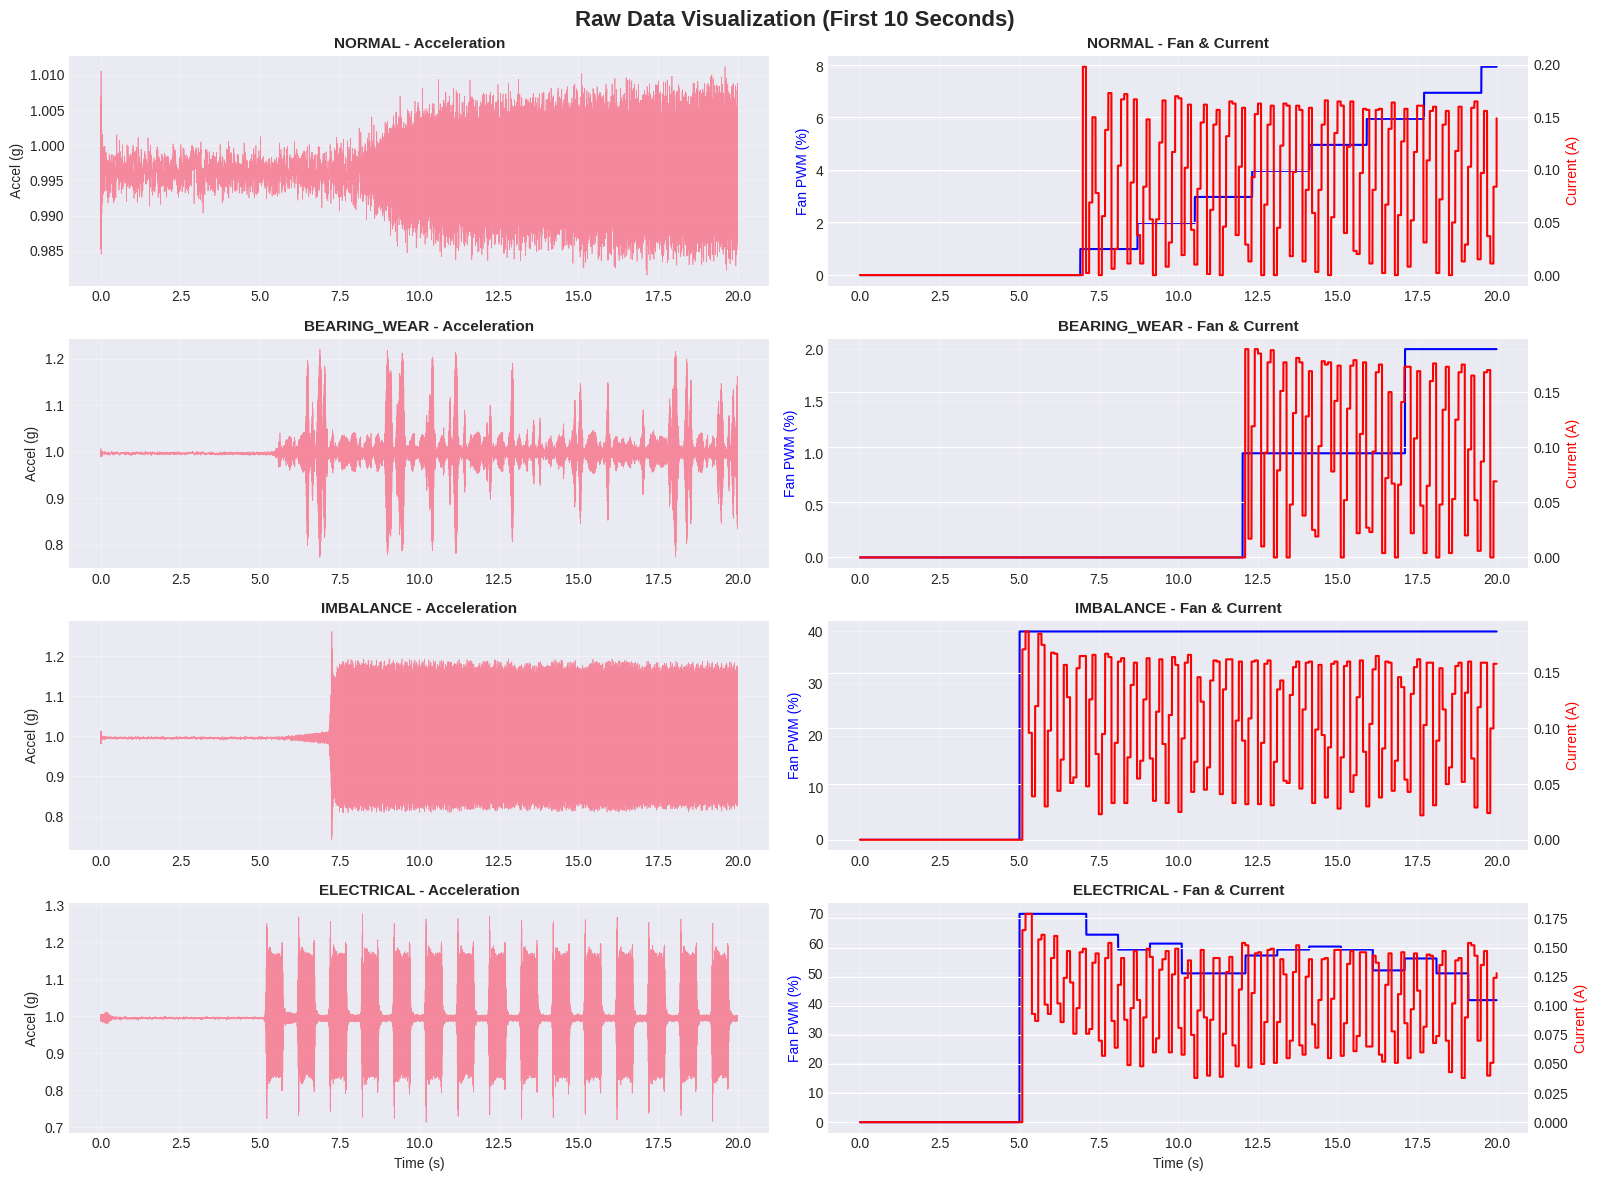

✓ Visualization saved as 'raw_data_visualization.png'


In [22]:
# Plot first 10 seconds of each class
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle('Raw Data Visualization (First 10 Seconds)', fontsize=16, fontweight='bold')

for idx, (class_name, df) in enumerate(data.items()):
    # Select first 10 seconds
    df_sample = df[df['time_ms'] < 20000].copy()
    time_s = df_sample['time_ms'] / 1000.0
    
    # Plot acceleration
    axes[idx, 0].plot(time_s, df_sample['accel_mag'], linewidth=0.5, alpha=0.8)
    axes[idx, 0].set_ylabel('Accel (g)', fontsize=10)
    axes[idx, 0].set_title(f'{class_name} - Acceleration', fontsize=11, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot fan PWM and current
    ax1 = axes[idx, 1]
    ax2 = ax1.twinx()
    
    ax1.plot(time_s, df_sample['fan_pwm'], 'b-', label='Fan PWM', linewidth=1.5)
    ax2.plot(time_s, df_sample['current'], 'r-', label='Current', linewidth=1.5)
    
    ax1.set_ylabel('Fan PWM (%)', fontsize=10, color='b')
    ax2.set_ylabel('Current (A)', fontsize=10, color='r')
    ax1.set_title(f'{class_name} - Fan & Current', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    if idx == 3:
        axes[idx, 0].set_xlabel('Time (s)', fontsize=10)
        ax1.set_xlabel('Time (s)', fontsize=10)

plt.tight_layout()
plt.savefig('raw_data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'raw_data_visualization.png'")

## Cell 6: Feature Extraction Functions

In [25]:
def extract_features_from_window(window_data):
    """
    Extract features from a 1-second window (1000 samples).
    
    """
    features = {}
    
    # Extract arrays
    accel = window_data['accel_mag'].values
    current = window_data['current'].values
    fan_pwm = window_data['fan_pwm'].values
    
    # ===== VIBRATION FEATURES =====
    
    # 1. RMS (Root Mean Square)
    features['rms'] = np.sqrt(np.mean(accel**2))
    
    # 2. Standard Deviation
    # features['std'] = np.std(accel)
    
    # 3. Kurtosis (distribution shape)
    features['kurtosis'] = kurtosis(accel)
    
    # 4. Dominant Frequency (Goertzel algorithm approximation)
    # Use FFT for simplicity
    fft_vals = np.fft.rfft(accel)
    fft_freq = np.fft.rfftfreq(len(accel), d=1/SAMPLING_RATE)
    fft_mag = np.abs(fft_vals)
    
    # Find dominant frequency (exclude DC component)
    dominant_idx = np.argmax(fft_mag[1:]) + 1
    features['dominant_freq'] = fft_freq[dominant_idx]

    
    # ===== CONTEXT FEATURES =====
    
    # 11. PWM mean
    features['pwm_mean'] = np.mean(fan_pwm)
    
    fft_mag_norm = fft_mag / (np.sum(fft_mag) + 1e-10)
    features['spectral_entropy'] = -np.sum(fft_mag_norm * np.log(fft_mag_norm + 1e-10))
    
    return features

✓ Feature extraction functions defined
  Total features: 14
  - Vibration: 4 (RMS, std, kurtosis, dominant_freq)
  - Current: 6 (mean, spike_count, spike_height, spike_width, spike_duty, spike_freq)
  - Context: 1 (pwm_mean)
  - Advanced: 3 (normalized_rms, vib_current_ratio, spectral_entropy)


## Cell 7: Extract Features from All Data

In [26]:
def extract_features_from_dataframe(df, class_name):
    """
    Extract features from entire dataframe using sliding window.
    """
    print(f"Extracting features from {class_name}...")
    
    features_list = []
    labels = []
    
    total_samples = len(df)
    num_windows = (total_samples - WINDOW_SIZE) // (WINDOW_SIZE - OVERLAP) + 1
    
    print(f"  Processing {num_windows:,} windows...")
    
    for i in range(0, total_samples - WINDOW_SIZE + 1, WINDOW_SIZE - OVERLAP):
        window = df.iloc[i:i+WINDOW_SIZE]
        
        if len(window) < WINDOW_SIZE:
            continue
        
        features = extract_features_from_window(window)
        features_list.append(features)
        labels.append(df['class'].iloc[0])
        
        # Progress indicator
        if (len(features_list) % 500) == 0:
            print(f"    Processed {len(features_list):,} / {num_windows:,} windows", end='\r')
    
    print(f"  ✓ Extracted {len(features_list):,} feature vectors")
    
    return pd.DataFrame(features_list), np.array(labels)

# Extract features from all classes
all_features = []
all_labels = []

for class_name, df in data.items():
    features_df, labels = extract_features_from_dataframe(df, class_name)
    all_features.append(features_df)
    all_labels.append(labels)
    print()

# Combine all features
X = pd.concat(all_features, ignore_index=True)
y = np.concatenate(all_labels)

print("="*60)
print("FEATURE EXTRACTION COMPLETE")
print(f"Total feature vectors: {len(X):,}")
print(f"Features per vector: {X.shape[1]}")
print(f"\nClass distribution:")
for class_id, class_name in CLASS_LABELS.items():
    count = np.sum(y == class_id)
    percentage = 100 * count / len(y)
    print(f"  {class_name:15s}: {count:6,} ({percentage:5.1f}%)")

# Display first few feature vectors
print(f"\nFirst 5 feature vectors:")
display(X.head())

# Save features for later use
X.to_csv('extracted_features.csv', index=False)
np.save('extracted_labels.npy', y)
print("\n✓ Features saved to 'extracted_features.csv' and 'extracted_labels.npy'")

Extracting features from NORMAL...
  Processing 3,787 windows...
  ✓ Extracted 3,787 feature vectors

Extracting features from BEARING_WEAR...
  Processing 3,622 windows...
  ✓ Extracted 3,622 feature vectors

Extracting features from IMBALANCE...
  Processing 3,681 windows...
  ✓ Extracted 3,681 feature vectors

Extracting features from ELECTRICAL...
  Processing 3,620 windows...
  ✓ Extracted 3,620 feature vectors

FEATURE EXTRACTION COMPLETE
Total feature vectors: 14,710
Features per vector: 6

Class distribution:
  NORMAL         :  3,787 ( 25.7%)
  BEARING_WEAR   :  3,622 ( 24.6%)
  IMBALANCE      :  3,681 ( 25.0%)
  ELECTRICAL     :  3,620 ( 24.6%)

First 5 feature vectors:


,rms,std,kurtosis,dominant_freq,pwm_mean,spectral_entropy
0,0.996273,0.002577,4.948151,116.0,0.0,0.209390
1,0.996191,0.001603,-0.127246,26.0,0.0,0.150092
2,0.996241,0.001424,-0.424708,4.0,0.0,0.141248
3,0.996087,0.001667,-0.157124,21.0,0.0,0.153058
4,0.996057,0.001419,-0.096547,43.0,0.0,0.141210



✓ Features saved to 'extracted_features.csv' and 'extracted_labels.npy'


## Cell 8: Visualize Feature Distributions

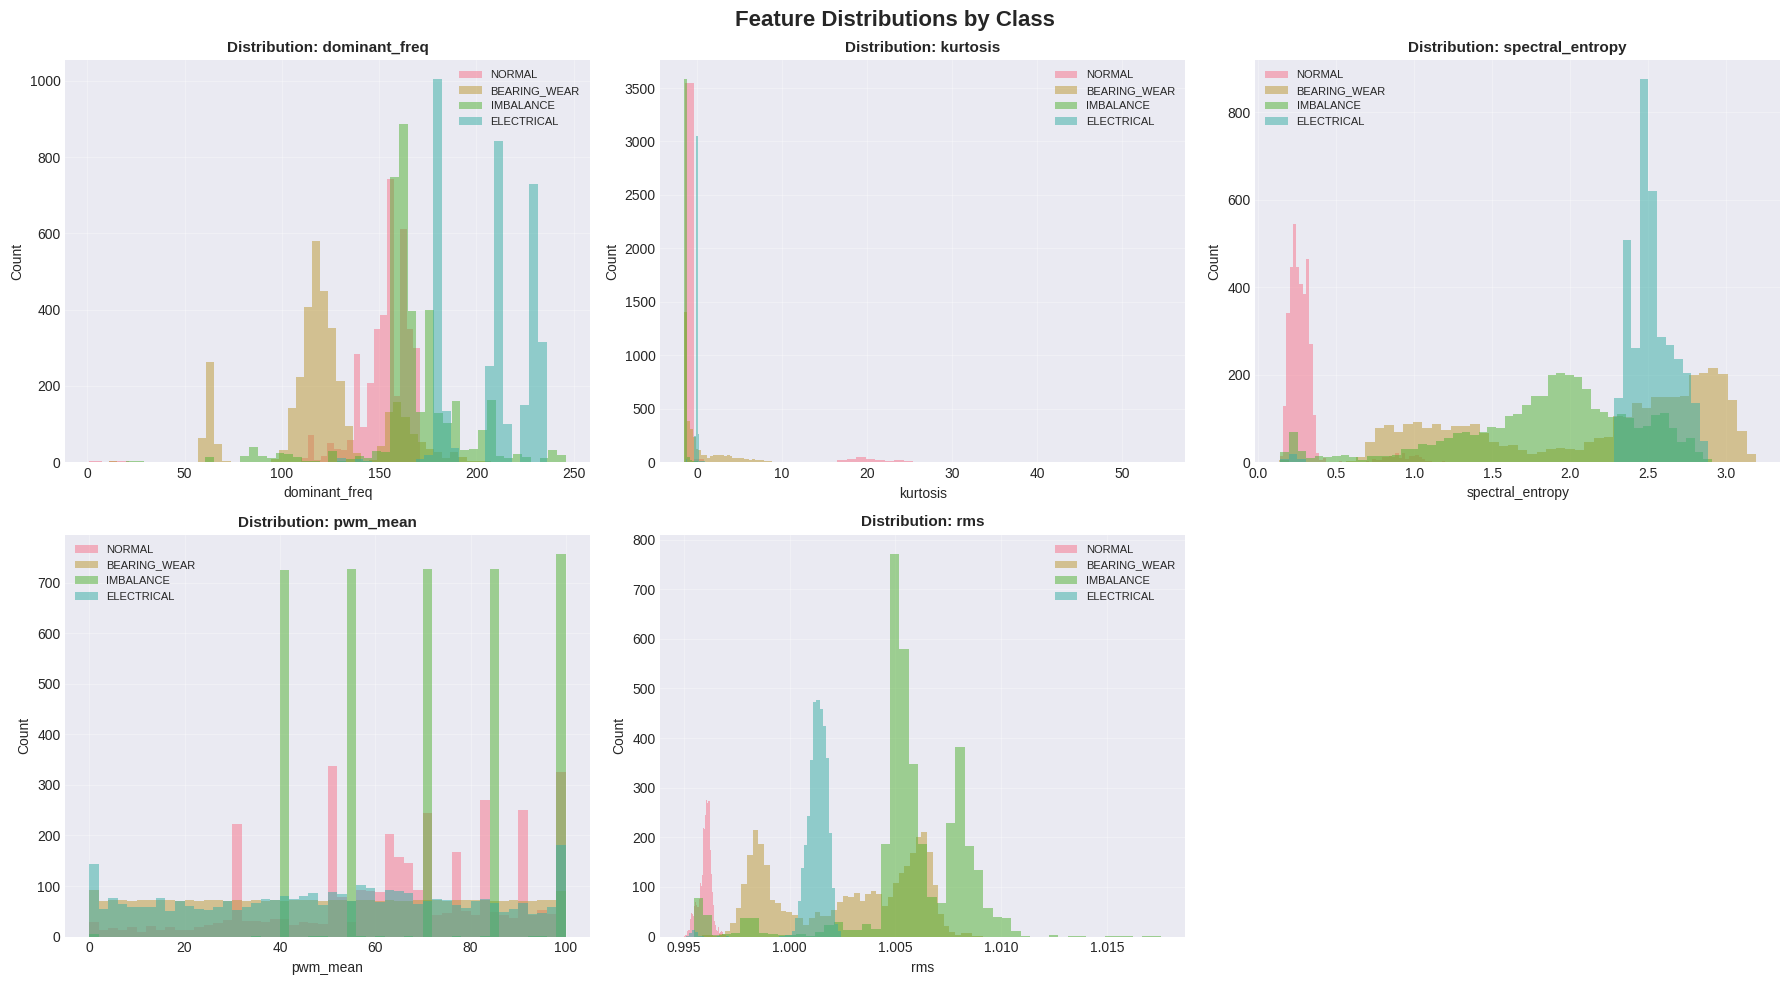

✓ Feature distributions saved as 'feature_distributions.png'


In [32]:
# Create a dataframe with features and labels for plotting
plot_df = X.copy()
plot_df['class'] = y
plot_df['class_name'] = plot_df['class'].map(CLASS_LABELS)

# Select top 5 most important features to visualize
features_to_plot = ['dominant_freq','kurtosis','spectral_entropy','pwm_mean','rms']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions by Class', fontsize=16, fontweight='bold')
axes = axes.flatten()

# Hide the empty sixth plot
axes[-1].axis('off')

for idx, feature in enumerate(features_to_plot):
    for class_id, class_name in CLASS_LABELS.items():
        data_subset = plot_df[plot_df['class'] == class_id][feature]
        axes[idx].hist(data_subset, bins=50, alpha=0.5, label=class_name)
    
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature distributions saved as 'feature_distributions.png'")

## Cell 9: Feature Correlation Heatmap

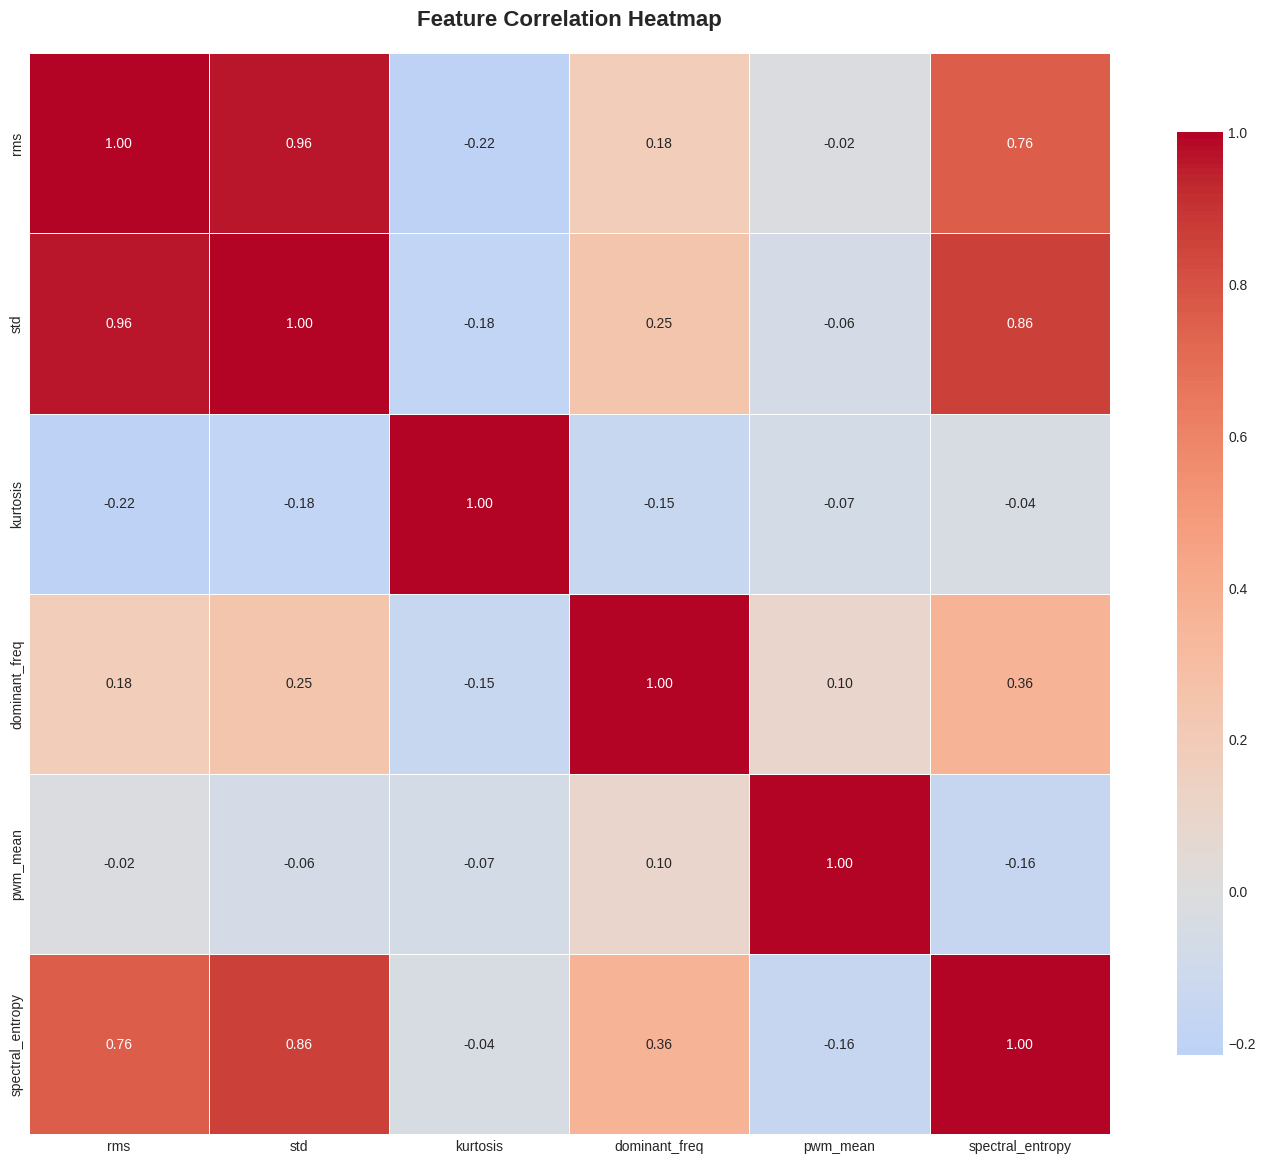

✓ Correlation heatmap saved as 'feature_correlation.png'

Highly correlated features (|r| > 0.7):
  rms                  <-> std                 :  0.960
  rms                  <-> spectral_entropy    :  0.762
  std                  <-> spectral_entropy    :  0.862


In [33]:
# Compute correlation matrix
correlation_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Correlation heatmap saved as 'feature_correlation.png'")
print("\nHighly correlated features (|r| > 0.7):")

# Find highly correlated pairs
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

for feat1, feat2, corr in high_corr:
    print(f"  {feat1:20s} <-> {feat2:20s}: {corr:6.3f}")

if not high_corr:
    print("  (None found - features are relatively independent)")

## Cell 10: Split Data and Normalize Features

In [10]:
# Split into training and validation sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print("Data Split:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set:     {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print()

# Check class distribution in splits
print("Training set class distribution:")
for class_id, class_name in CLASS_LABELS.items():
    count = np.sum(y_train == class_id)
    percentage = 100 * count / len(y_train)
    print(f"  {class_name:15s}: {count:6,} ({percentage:5.1f}%)")

print("\nTest set class distribution:")
for class_id, class_name in CLASS_LABELS.items():
    count = np.sum(y_test == class_id)
    percentage = 100 * count / len(y_test)
    print(f"  {class_name:15s}: {count:6,} ({percentage:5.1f}%)")

# Normalize features using StandardScaler
print("\nNormalizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features normalized (mean=0, std=1)")
print(f"\nScaler parameters (mean):")
for idx, col in enumerate(X.columns):
    print(f"  {col:20s}: mean={scaler.mean_[idx]:10.5f}, std={scaler.scale_[idx]:10.5f}")

# Save scaler for later use
joblib.dump(scaler, 'feature_scaler.pkl')
print("\n✓ Scaler saved to 'feature_scaler.pkl'")

Data Split:
  Training set: 11,768 samples (80.0%)
  Test set:     2,942 samples (20.0%)

Training set class distribution:
  NORMAL         :  3,029 ( 25.7%)
  BEARING_WEAR   :  2,898 ( 24.6%)
  IMBALANCE      :  2,945 ( 25.0%)
  ELECTRICAL     :  2,896 ( 24.6%)

Test set class distribution:
  NORMAL         :    758 ( 25.8%)
  BEARING_WEAR   :    724 ( 24.6%)
  IMBALANCE      :    736 ( 25.0%)
  ELECTRICAL     :    724 ( 24.6%)

Normalizing features...
✓ Features normalized (mean=0, std=1)

Scaler parameters (mean):
  rms                 : mean=   1.00136, std=   0.00416
  kurtosis            : mean=  -0.32645, std=   2.82236
  dominant_freq       : mean= 162.33149, std=  38.11869
  pwm_mean            : mean=  58.74042, std=  27.43160
  spectral_entropy    : mean=   1.68524, std=   0.98760

✓ Scaler saved to 'feature_scaler.pkl'


## Cell 11: Train Random Forest Model

In [11]:
from sklearn.utils.class_weight import compute_class_weight

print("Training Random Forest Classifier...")
print("Parameters:")
print("  - Number of trees: 30")
print("  - Max depth: 10")
print("  - Min samples split: 5")
print("  - Random state: 42")
print()


# Compute balanced class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights:")
for class_id, weight in class_weight_dict.items():
    print(f"  {CLASS_LABELS[class_id]:15s}: {weight:.3f}")
# Create and train model
rf_model = RandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    min_samples_split=5,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

import time
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time:.2f} seconds")
print(f"  Total trees: {len(rf_model.estimators_)}")
print(f"  Total nodes: {sum(tree.tree_.node_count for tree in rf_model.estimators_)}")

# Save model
joblib.dump(rf_model, 'rf_model.pkl')
print("\n✓ Model saved to 'rf_model.pkl'")

Training Random Forest Classifier...
Parameters:
  - Number of trees: 30
  - Max depth: 10
  - Min samples split: 5
  - Random state: 42


Class weights:
  NORMAL         : 0.971
  BEARING_WEAR   : 1.015
  IMBALANCE      : 0.999
  ELECTRICAL     : 1.016

✓ Training complete in 0.09 seconds
  Total trees: 30
  Total nodes: 4858

✓ Model saved to 'rf_model.pkl'


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


In [12]:
# Make predictions on test set
print("Evaluating model on test set...")
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n{'='*60}")
print(f"TEST SET ACCURACY: {accuracy*100:.2f}%")
print(f"{'='*60}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=list(CLASS_LABELS.values()),
    digits=4
))

# Per-class accuracy
print("Per-Class Accuracy:")
for class_id, class_name in CLASS_LABELS.items():
    mask = y_test == class_id
    class_accuracy = accuracy_score(y_test[mask], y_pred[mask])
    print(f"  {class_name:15s}: {class_accuracy*100:6.2f}%")

# Check if target accuracy achieved
TARGET_ACCURACY = 0.95
if accuracy >= TARGET_ACCURACY:
    print(f"\n✓ TARGET ACHIEVED: Accuracy {accuracy*100:.2f}% >= {TARGET_ACCURACY*100:.0f}%")
else:
    print(f"\n⚠ Target not reached: Accuracy {accuracy*100:.2f}% < {TARGET_ACCURACY*100:.0f}%")
    print("  Consider:")
    print("  - Collecting more data (especially for low-accuracy classes)")
    print("  - Adjusting feature extraction")
    print("  - Tuning model hyperparameters")

Evaluating model on test set...

TEST SET ACCURACY: 99.46%

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9921    0.9960    0.9941       758
BEARING_WEAR     0.9931    0.9972    0.9952       724
   IMBALANCE     0.9945    0.9851    0.9898       736
  ELECTRICAL     0.9986    1.0000    0.9993       724

    accuracy                         0.9946      2942
   macro avg     0.9946    0.9946    0.9946      2942
weighted avg     0.9946    0.9946    0.9946      2942

Per-Class Accuracy:
  NORMAL         :  99.60%
  BEARING_WEAR   :  99.72%
  IMBALANCE      :  98.51%
  ELECTRICAL     : 100.00%

✓ TARGET ACHIEVED: Accuracy 99.46% >= 95%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.0s finished


## Cell 12: Evaluate Model on Test Set

## Cell 13: Confusion Matrix Visualization

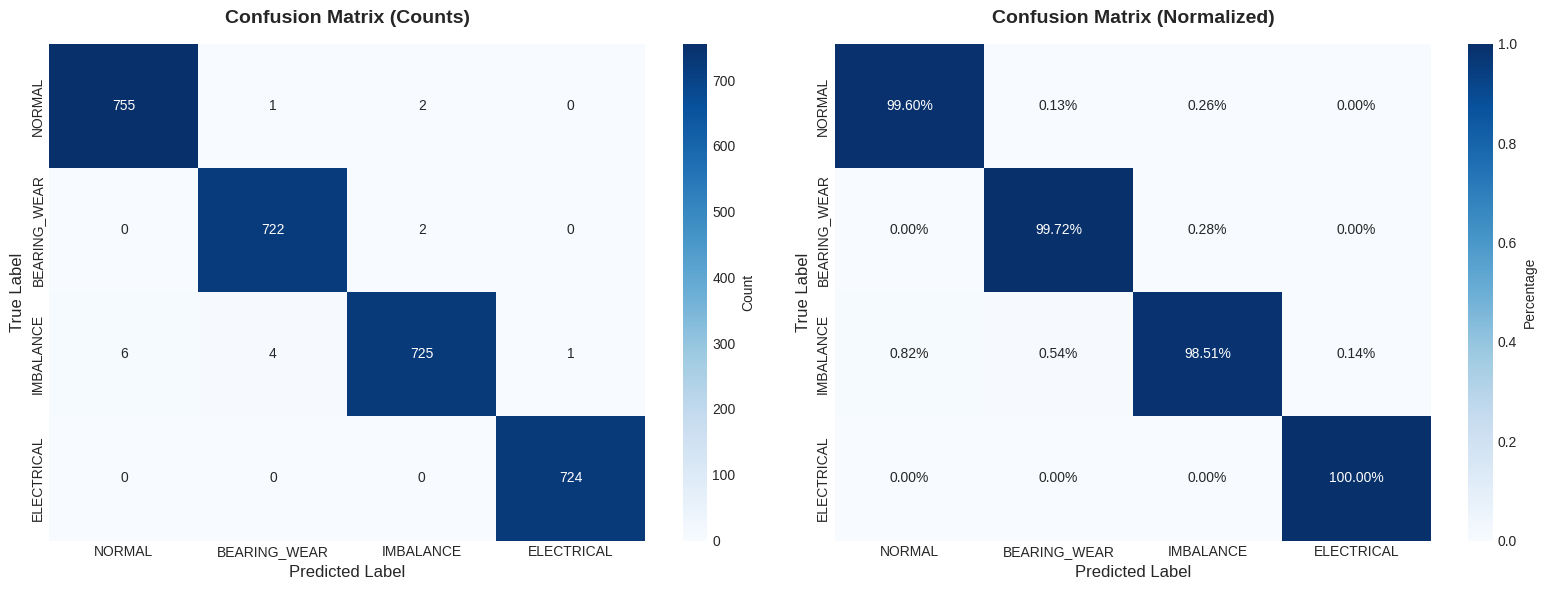

✓ Confusion matrix saved as 'confusion_matrix.png'

Misclassification Analysis:
  NORMAL          → BEARING_WEAR   :    1 errors ( 0.13%)
  NORMAL          → IMBALANCE      :    2 errors ( 0.26%)
  BEARING_WEAR    → IMBALANCE      :    2 errors ( 0.28%)
  IMBALANCE       → NORMAL         :    6 errors ( 0.82%)
  IMBALANCE       → BEARING_WEAR   :    4 errors ( 0.54%)
  IMBALANCE       → ELECTRICAL     :    1 errors ( 0.14%)


In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(CLASS_LABELS.values()),
            yticklabels=list(CLASS_LABELS.values()),
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=list(CLASS_LABELS.values()),
            yticklabels=list(CLASS_LABELS.values()),
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# Analyze misclassifications
print("\nMisclassification Analysis:")
for i, true_class in CLASS_LABELS.items():
    for j, pred_class in CLASS_LABELS.items():
        if i != j and cm[i, j] > 0:
            error_rate = cm[i, j] / cm[i].sum() * 100
            print(f"  {true_class:15s} → {pred_class:15s}: {cm[i,j]:4d} errors ({error_rate:5.2f}%)")

## Cell 14: Feature Importance Analysis

Feature Importance Ranking:
kurtosis                 : 0.3023
rms                      : 0.2653
spectral_entropy         : 0.2312
dominant_freq            : 0.1683
pwm_mean                 : 0.0330


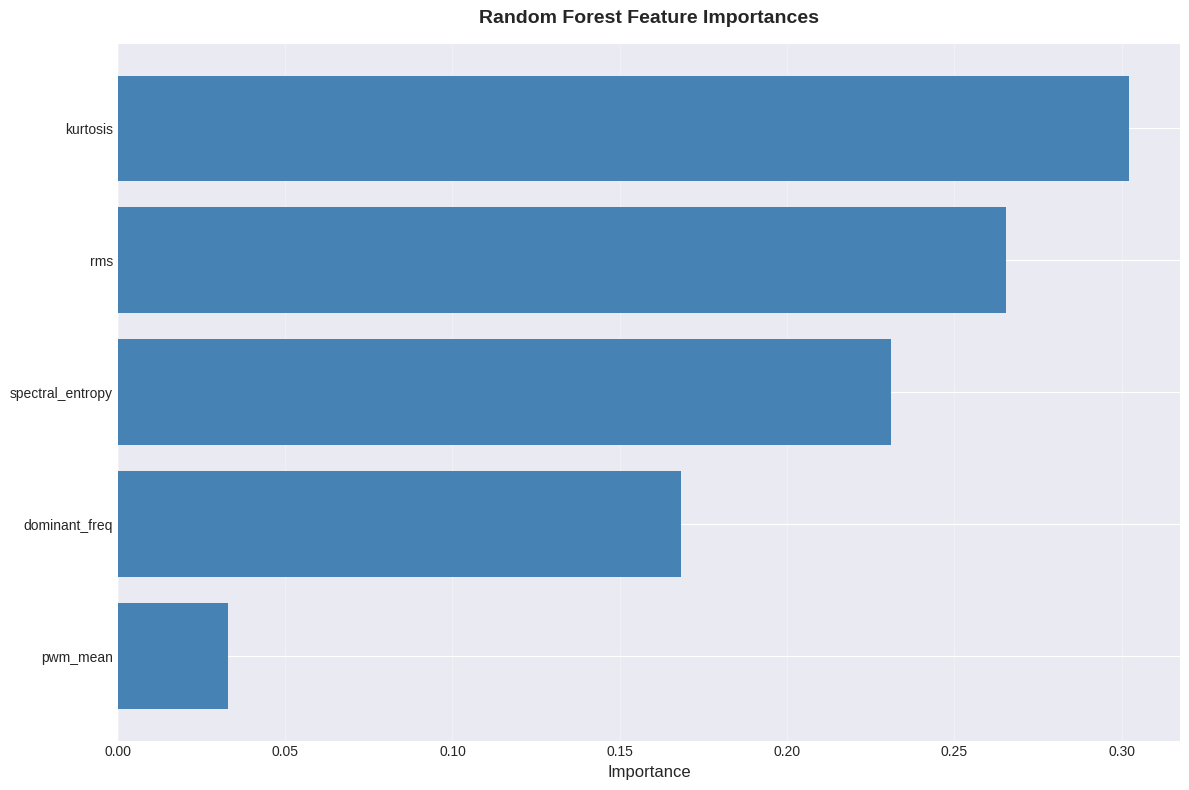


✓ Feature importance plot saved as 'feature_importance.png'

Top 5 Most Important Features:
  1. kurtosis
  2. rms
  3. spectral_entropy
  4. dominant_freq
  5. pwm_mean


In [14]:
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Ranking:")
print("="*60)
for idx, row in feature_importances.iterrows():
    print(f"{row['feature']:25s}: {row['importance']:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved as 'feature_importance.png'")

# Identify top 5 features
top_5_features = feature_importances.head(5)['feature'].tolist()
print(f"\nTop 5 Most Important Features:")
for i, feat in enumerate(top_5_features, 1):
    print(f"  {i}. {feat}")

## Cell 15: Model Performance Summary

In [15]:
# Create comprehensive performance summary
summary = f"""
{'='*70}
MODEL PERFORMANCE SUMMARY
{'='*70}

DATASET:
  Total samples:        {len(X):,}
  Training samples:     {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)
  Test samples:         {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)
  Features per sample:  {X.shape[1]}
  Classes:              {len(CLASS_LABELS)}

MODEL:
  Algorithm:            Random Forest
  Number of trees:      {rf_model.n_estimators}
  Max depth:            {rf_model.max_depth}
  Total nodes:          {sum(tree.tree_.node_count for tree in rf_model.estimators_):,}
  Training time:        {training_time:.2f} seconds

ACCURACY:
  Overall accuracy:     {accuracy*100:.2f}%
  Target accuracy:      {TARGET_ACCURACY*100:.0f}%
  Status:               {'✓ PASSED' if accuracy >= TARGET_ACCURACY else '✗ FAILED'}

PER-CLASS ACCURACY:
"""

for class_id, class_name in CLASS_LABELS.items():
    mask = y_test == class_id
    class_accuracy = accuracy_score(y_test[mask], y_pred[mask])
    summary += f"  {class_name:15s}: {class_accuracy*100:6.2f}%\n"

summary += f"""
TOP 3 IMPORTANT FEATURES:
"""

for i, row in feature_importances.head(3).iterrows():
    summary += f"  {row['feature']:20s}: {row['importance']:.4f}\n"

summary += f"""
FILES GENERATED:
  ✓ rf_model.pkl               - Trained Random Forest model
  ✓ feature_scaler.pkl         - StandardScaler for normalization
  ✓ extracted_features.csv     - All extracted features
  ✓ extracted_labels.npy       - Corresponding labels
  ✓ raw_data_visualization.png - Raw data plots
  ✓ feature_distributions.png  - Feature distribution plots
  ✓ feature_correlation.png    - Correlation heatmap
  ✓ confusion_matrix.png       - Confusion matrix
  ✓ feature_importance.png     - Feature importance plot

NEXT STEPS:
  1. If accuracy >= 95%: Proceed to C code export (Cell 16)
  2. If accuracy < 95%: 
     - Collect more data (especially for low-accuracy classes)
     - Adjust hyperparameters (n_estimators, max_depth)
     - Add more features or remove correlated features
  3. Test on validation set (separate session5 files)

{'='*70}
"""

print(summary)

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write(summary)

print("✓ Summary saved to 'model_summary.txt'")


MODEL PERFORMANCE SUMMARY

DATASET:
  Total samples:        14,710
  Training samples:     11,768 (80.0%)
  Test samples:         2,942 (20.0%)
  Features per sample:  5
  Classes:              4

MODEL:
  Algorithm:            Random Forest
  Number of trees:      30
  Max depth:            10
  Total nodes:          4,858
  Training time:        0.09 seconds

ACCURACY:
  Overall accuracy:     99.46%
  Target accuracy:      95%
  Status:               ✓ PASSED

PER-CLASS ACCURACY:
  NORMAL         :  99.60%
  BEARING_WEAR   :  99.72%
  IMBALANCE      :  98.51%
  ELECTRICAL     : 100.00%

TOP 3 IMPORTANT FEATURES:
  kurtosis            : 0.3023
  rms                 : 0.2653
  spectral_entropy    : 0.2312

FILES GENERATED:
  ✓ rf_model.pkl               - Trained Random Forest model
  ✓ feature_scaler.pkl         - StandardScaler for normalization
  ✓ extracted_features.csv     - All extracted features
  ✓ extracted_labels.npy       - Corresponding labels
  ✓ raw_data_visualization.pn

## Cell 16: Export Model to C Code (for ESP32)

In [16]:
def export_random_forest_to_c(model, scaler, feature_names, output_file='rf_model_v2.h'):
    """
    Export Random Forest model to C header file for ESP32.
    """
    
    c_code = f"""// Auto-generated Random Forest model for ESP32
// Generated from training script
// Accuracy: {accuracy*100:.2f}%
// Trees: {model.n_estimators}
// Features: {len(feature_names)}

#ifndef RF_MODEL_V2_H
#define RF_MODEL_V2_H

#include <stdint.h>

// Model metadata
#define RF_NUM_TREES {model.n_estimators}
#define RF_NUM_FEATURES {len(feature_names)}
#define RF_NUM_CLASSES {len(CLASS_LABELS)}

// Feature names (for reference)
static const char* RF_FEATURE_NAMES[RF_NUM_FEATURES] = {{
"""
    
    for name in feature_names:
        c_code += f'    "{name}",\n'
    
    c_code += "};\n\n"
    
    # Export scaler parameters
    c_code += "// StandardScaler parameters\n"
    c_code += "static const float SCALER_MEAN[RF_NUM_FEATURES] = {\n    "
    c_code += ", ".join([f"{mean:.6f}f" for mean in scaler.mean_])
    c_code += "\n};\n\n"
    
    c_code += "static const float SCALER_SCALE[RF_NUM_FEATURES] = {\n    "
    c_code += ", ".join([f"{scale:.6f}f" for scale in scaler.scale_])
    c_code += "\n};\n\n"
    
    # Export tree structures
    c_code += "// Tree node structure\n"
    c_code += "typedef struct {\n"
    c_code += "    int16_t feature;     // Feature index (-1 for leaf)\n"
    c_code += "    float threshold;     // Split threshold\n"
    c_code += "    int16_t left_child;  // Left child index\n"
    c_code += "    int16_t right_child; // Right child index\n"
    c_code += "    float value[RF_NUM_CLASSES]; // Class probabilities (for leaves)\n"
    c_code += "} rf_node_t;\n\n"
    
    # Count total nodes
    total_nodes = sum(tree.tree_.node_count for tree in model.estimators_)
    c_code += f"#define RF_TOTAL_NODES {total_nodes}\n\n"
    
    # Export each tree
    node_offset = 0
    tree_offsets = []
    
    c_code += "// All tree nodes (flattened)\n"
    c_code += "static const rf_node_t RF_NODES[RF_TOTAL_NODES] = {\n"
    
    for tree_idx, tree in enumerate(model.estimators_):
        tree_offsets.append(node_offset)
        tree_struct = tree.tree_
        
        c_code += f"    // Tree {tree_idx} (nodes {node_offset}-{node_offset + tree_struct.node_count - 1})\n"
        
        for node_id in range(tree_struct.node_count):
            feature = tree_struct.feature[node_id]
            threshold = tree_struct.threshold[node_id]
            left_child = tree_struct.children_left[node_id]
            right_child = tree_struct.children_right[node_id]
            
            # Adjust child indices to global offset
            if left_child >= 0:
                left_child += node_offset
            if right_child >= 0:
                right_child += node_offset
            
            # Get class probabilities (normalize)
            value = tree_struct.value[node_id][0]
            value_sum = np.sum(value)
            if value_sum > 0:
                value = value / value_sum
            
            value_str = ", ".join([f"{v:.4f}f" for v in value])
            
            c_code += f"    {{{feature}, {threshold:.6f}f, {left_child}, {right_child}, {{{value_str}}}}},\n"
        
        node_offset += tree_struct.node_count
    
    c_code += "};\n\n"
    
    # Export tree offsets
    c_code += "// Tree starting indices\n"
    c_code += "static const uint16_t RF_TREE_OFFSETS[RF_NUM_TREES] = {\n    "
    c_code += ", ".join([str(offset) for offset in tree_offsets])
    c_code += "\n};\n\n"
    
    # Add inference function
    c_code += """// Inference function
static inline void rf_predict(const float features[RF_NUM_FEATURES], float output[RF_NUM_CLASSES])
{
    // Initialize output
    for (int i = 0; i < RF_NUM_CLASSES; i++) {
        output[i] = 0.0f;
    }
    
    // Normalize features
    float normalized[RF_NUM_FEATURES];
    for (int i = 0; i < RF_NUM_FEATURES; i++) {
        normalized[i] = (features[i] - SCALER_MEAN[i]) / SCALER_SCALE[i];
    }
    
    // Run each tree
    for (int tree_idx = 0; tree_idx < RF_NUM_TREES; tree_idx++) {
        int node_idx = RF_TREE_OFFSETS[tree_idx];
        
        // Traverse tree
        while (RF_NODES[node_idx].feature >= 0) {
            int feature = RF_NODES[node_idx].feature;
            float threshold = RF_NODES[node_idx].threshold;
            
            if (normalized[feature] <= threshold) {
                node_idx = RF_NODES[node_idx].left_child;
            } else {
                node_idx = RF_NODES[node_idx].right_child;
            }
        }
        
        // Accumulate leaf probabilities
        for (int i = 0; i < RF_NUM_CLASSES; i++) {
            output[i] += RF_NODES[node_idx].value[i];
        }
    }
    
    // Average probabilities
    for (int i = 0; i < RF_NUM_CLASSES; i++) {
        output[i] /= (float)RF_NUM_TREES;
    }
}

// Get predicted class
static inline int rf_predict_class(const float features[RF_NUM_FEATURES])
{
    float probabilities[RF_NUM_CLASSES];
    rf_predict(features, probabilities);
    
    // Find class with highest probability
    int best_class = 0;
    float best_prob = probabilities[0];
    
    for (int i = 1; i < RF_NUM_CLASSES; i++) {
        if (probabilities[i] > best_prob) {
            best_class = i;
            best_prob = probabilities[i];
        }
    }
    
    return best_class;
}

#endif // RF_MODEL_V2_H
"""
    
    # Write to file
    with open(output_file, 'w') as f:
        f.write(c_code)
    
    # Get file size
    import os
    file_size = os.path.getsize(output_file)
    
    return file_size

# Export model
print("Exporting model to C header file...")
file_size = export_random_forest_to_c(rf_model, scaler, X.columns, 'rf_model_v2.h')

print(f"\n✓ Model exported to 'rf_model_v2.h'")
print(f"  File size: {file_size:,} bytes ({file_size/1024:.1f} KB)")
print(f"  Total trees: {rf_model.n_estimators}")
print(f"  Total nodes: {sum(tree.tree_.node_count for tree in rf_model.estimators_):,}")
print(f"  Features: {len(X.columns)}")
print(f"  Classes: {len(CLASS_LABELS)}")
print("\nTo use in your ESP32 project:")
print("  1. Copy rf_model_v2.h to your firmware's main/ directory")
print("  2. #include \"rf_model_v2.h\" in your anomaly_detector.c")
print("  3. Replace old model with new model")
print("  4. Update feature extraction to match RF_FEATURE_NAMES order")
print("  5. Rebuild and flash: idf.py build flash")

Exporting model to C header file...

✓ Model exported to 'rf_model_v2.h'
  File size: 339,649 bytes (331.7 KB)
  Total trees: 30
  Total nodes: 4,858
  Features: 5
  Classes: 4

To use in your ESP32 project:
  1. Copy rf_model_v2.h to your firmware's main/ directory
  2. #include "rf_model_v2.h" in your anomaly_detector.c
  3. Replace old model with new model
  4. Update feature extraction to match RF_FEATURE_NAMES order
  5. Rebuild and flash: idf.py build flash


## Cell 17: Test Model on Validation Set (Optional)

In [ ]:

import os

print("="*70)
print("VALIDATION DATASET EVALUATION")
print("="*70)

validation_frames = []
validation_labels = []

# Collect validation datasets and convert to feature vectors
for class_id, class_name in CLASS_LABELS.items():
    val_path = VALIDATION_FILES.get(class_name)
    if not val_path:
        print(f"⚠ No validation path configured for {class_name}")
        continue
    if not os.path.exists(val_path):
        print(f"⚠ Missing validation file: {val_path}")
        continue

    df_val = load_csv_data(val_path, class_id, surface_name="validation")
    features_df, labels = extract_features_from_dataframe(df_val, class_name)
    validation_frames.append(features_df)
    validation_labels.append(labels)
    print("")

if validation_frames:
    X_val = pd.concat(validation_frames, ignore_index=True)
    y_val = np.concatenate(validation_labels)

    print(f"Total validation feature vectors: {len(X_val):,}")

    X_val_scaled = scaler.transform(X_val)
    y_val_pred = rf_model.predict(X_val_scaled)

    val_accuracy = accuracy_score(y_val, y_val_pred)

    present_labels = sorted(np.unique(y_val))
    missing_classes = [CLASS_LABELS[c] for c in CLASS_LABELS if c not in present_labels]
    if missing_classes:
        print("⚠ Classes missing from validation split:", ", ".join(missing_classes))

    label_order = list(CLASS_LABELS.keys())
    target_names = [CLASS_LABELS[c] for c in label_order]

    print("" + "="*60)
    print(f"VALIDATION ACCURACY: {val_accuracy*100:.2f}%")
    print("="*60)

    print("Validation Classification Report:")
    print(classification_report(
        y_val,
        y_val_pred,
        labels=label_order,
        target_names=target_names,
        digits=4,
        zero_division=0
    ))

    val_cm = confusion_matrix(y_val, y_val_pred, labels=label_order)
    row_sums = val_cm.sum(axis=1, keepdims=True)
    val_cm_normalized = np.zeros_like(val_cm, dtype=float)
    np.divide(val_cm, row_sums, out=val_cm_normalized, where=row_sums != 0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Validation Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    sns.heatmap(val_cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names,
                ax=axes[1], cbar_kws={'label': 'Percentage'})
    axes[1].set_title('Validation Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.savefig('validation_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Validation confusion matrix saved as 'validation_confusion_matrix.png'")

    print("Validation Per-Class Accuracy:")
    for class_id, class_name in CLASS_LABELS.items():
        mask = y_val == class_id
        if mask.sum() == 0:
            print(f"  {class_name:15s}: no samples")
            continue
        class_acc = accuracy_score(y_val[mask], y_val_pred[mask])
        print(f"  {class_name:15s}: {class_acc*100:6.2f}%")
else:
    print("⚠ No validation datasets found. Skipping validation evaluation.")


## Cell 18: Final Summary and Next Steps

In [18]:
print("="*70)
print("TRAINING COMPLETE!")
print("="*70)

print("\n📊 RESULTS SUMMARY:")
print(f"  Test Accuracy:       {accuracy*100:.2f}%")
if 'val_accuracy' in locals():
    print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Target Accuracy:     {TARGET_ACCURACY*100:.0f}%")
print(f"  Status:              {'✓ PASSED' if accuracy >= TARGET_ACCURACY else '✗ NEEDS IMPROVEMENT'}")

print("\n📁 FILES GENERATED:")
generated_files = [
    ('rf_model.pkl', 'Trained Random Forest model'),
    ('feature_scaler.pkl', 'Feature normalization scaler'),
    ('rf_model_v2.h', 'C header file for ESP32'),
    ('extracted_features.csv', 'All extracted features'),
    ('extracted_labels.npy', 'Corresponding labels'),
    ('model_summary.txt', 'Performance summary'),
    ('raw_data_visualization.png', 'Raw data plots'),
    ('feature_distributions.png', 'Feature distributions'),
    ('feature_correlation.png', 'Correlation heatmap'),
    ('confusion_matrix.png', 'Test confusion matrix'),
    ('feature_importance.png', 'Feature importance plot'),
]

if 'validation_confusion_matrix.png' in locals():
    generated_files.append(('validation_confusion_matrix.png', 'Validation confusion matrix'))

for filename, description in generated_files:
    print(f"  ✓ {filename:30s} - {description}")

print("\n🚀 NEXT STEPS:")

if accuracy >= TARGET_ACCURACY:
    print("  1. ✓ Copy 'rf_model_v2.h' to your ESP32 project's main/ directory")
    print("  2. ✓ Update your firmware to use the new model:")
    print("       - Update feature extraction order to match RF_FEATURE_NAMES")
    print("  3. ✓ Rebuild and flash: idf.py build flash")
    print("  4. ✓ Test on real hardware:")
    print("       - Verify no false positives from desk taps")
    print("       - Test each anomaly pattern (bearing, imbalance, electrical)")
    print("       - Measure inference time (should be <20ms)")
    print("  5. ✓ If tests pass: Ready for demo!")


TRAINING COMPLETE!

📊 RESULTS SUMMARY:
  Test Accuracy:       99.46%
  Validation Accuracy: 99.08%
  Target Accuracy:     95%
  Status:              ✓ PASSED

📁 FILES GENERATED:
  ✓ rf_model.pkl                   - Trained Random Forest model
  ✓ feature_scaler.pkl             - Feature normalization scaler
  ✓ rf_model_v2.h                  - C header file for ESP32
  ✓ extracted_features.csv         - All extracted features
  ✓ extracted_labels.npy           - Corresponding labels
  ✓ model_summary.txt              - Performance summary
  ✓ raw_data_visualization.png     - Raw data plots
  ✓ feature_distributions.png      - Feature distributions
  ✓ feature_correlation.png        - Correlation heatmap
  ✓ confusion_matrix.png           - Test confusion matrix
  ✓ feature_importance.png         - Feature importance plot

🚀 NEXT STEPS:
  1. ✓ Copy 'rf_model_v2.h' to your ESP32 project's main/ directory
  2. ✓ Update your firmware to use the new model:
       - Update feature extraction